In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from control import *
%matplotlib inline

In [2]:
sns.set_color_codes(palette='dark')
sns.set(style="whitegrid")

In [3]:
np.random.seed(0)

In [4]:
# define valve spool parameters
Ts = 0.01
m2 = 0.1
J = 10
Km = 2
Kc = 5
Ra = 1
La = 0.5
r = 5e-3
b2 = 25
b2f = 250
k1 = 2500

In [5]:
A1 = np.array([[0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, -Ra/La, -Kc/La],
    [0, 0, Km/(J+m2*r**2), -b2/(J+m2*r**2)]])
A2 = np.array([[0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, -Ra/La, -Kc/La],
    [0, 0, Km/(J+m2*r**2), -b2f/(J+m2*r**2)]])
B = np.array([[0, 0, 1/La, 0]]).transpose()
C = np.array([[0, 1, 0, 0]]) # change
D = 0

In [6]:
sysSS = ss(A1, B, C, D)
sysSSf = ss(A2, B, C, D)

In [7]:
tf1 = tf(sysSS)
print(tf1)


 8.882e-16 s + 0.4
-------------------
s^3 + 4.5 s^2 + 7 s



In [8]:
tf1 = c2d(tf(sysSS), Ts)
tf2 = c2d(tf(sysSSf), Ts)

print(tf1.den[0][0][1:])
print(tf1.num[0][0][1:])

[-2.95531304  2.91131053 -0.95599749]
[2.60735149e-07 6.44543841e-08]


/home/bsilva/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [9]:
fac = 1e7 #change
thn = np.concatenate((tf1.den[0][0][1:], fac*tf1.num[0][0][:]), axis=0)
thf = np.concatenate((tf2.den[0][0][1:], fac*tf2.num[0][0][:]), axis=0)

print(thn)
print(thf)

[-2.95531304  2.91131053 -0.95599749  0.6592105   2.60735149  0.64454384]
[-2.75882438  2.52220392 -0.76337954  0.62383267  2.33507008  0.54506852]


In [10]:
# number of measurements
T = 20
t = np.arange(0, T+Ts/2, Ts)
N = len(t)

sig = 0*1e-2 # noise corrupting measurements

print(N)

2001


In [11]:
# model parameters
a1 = np.concatenate((thn[0]*np.ones((1000,1)),
                        thf[0]*np.ones((1001,1))), axis=0)
a2 = np.concatenate((thn[1]*np.ones((1000,1)),
                        thf[1]*np.ones((1001,1))), axis=0)
a3 = np.concatenate((thn[2]*np.ones((1000,1)),
                        thf[2]*np.ones((1001,1))), axis=0)
b1 = np.concatenate((thn[3]*np.ones((1000,1)),
                        thf[3]*np.ones((1001,1))), axis=0)
b2 = np.concatenate((thn[4]*np.ones((1000,1)),
                        thf[4]*np.ones((1001,1))), axis=0)
b3 = np.concatenate((thn[5]*np.ones((1000,1)),
                        thf[5]*np.ones((1001,1))), axis=0)

print(a1[0])

[-2.95531304]


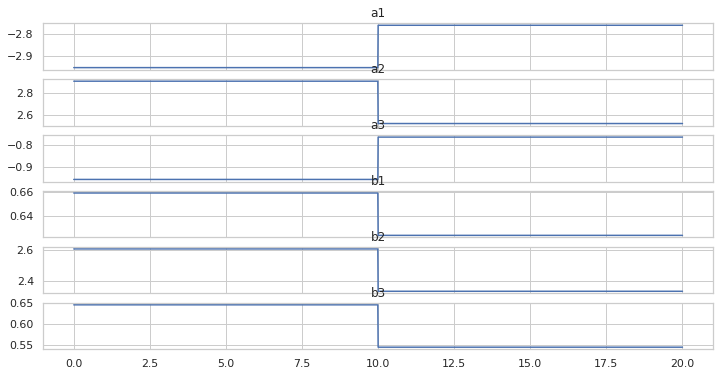

In [12]:
# plot parameters
fig,axes = plt.subplots(nrows=6, ncols=1, figsize=(12,6))

axes[0].set_title("a1")
axes[0].plot(t,a1,color='b')

axes[1].set_title("a2")
axes[1].plot(t,a2,color='b')

axes[2].set_title("a3")
axes[2].plot(t,a3,color='b')

axes[3].set_title("b1")
axes[3].plot(t,b1,color='b')

axes[4].set_title("b2")
axes[4].plot(t,b2,color='b')

axes[5].set_title("b3")
axes[5].plot(t,b3,color='b')

In [13]:
yr = np.zeros((N,1))
u = np.array(100*np.sin(2*np.pi*t)).reshape(N,1)

for k in range(4,N): # change
    phi = np.concatenate(([-yr[k-1]], [-yr[k-2]], [-yr[k-3]] , [u[k-1]], [u[k-2]], [u[k-3]]), axis=1).transpose()
    th = np.concatenate(([a1[k]], [a2[k]], [a3[k]], [1/fac*b1[k]], [1/fac*b2[k]], [1/fac*b3[k]]),\
                        axis=1).transpose()

    yr[k] = np.dot(phi.transpose(), th)
    
y = yr + sig*np.random.rand(N,1) # measurements (corrupted by noise)

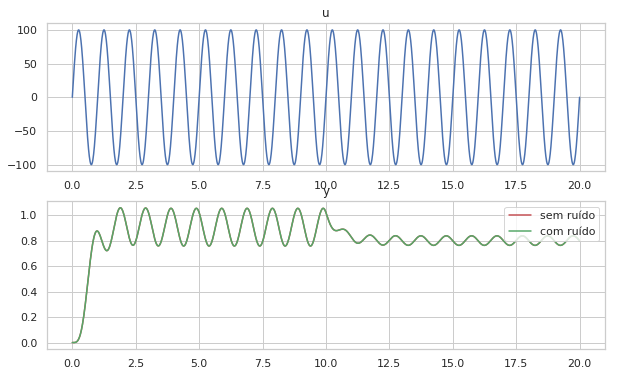

In [14]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))

axes[0].set_title("u")
axes[0].plot(t,u,color='b')

axes[1].set_title("y")
axes[1].plot(t,yr,color='r',label='sem ruído')
axes[1].plot(t,y,color='g',label='com ruído')
axes[1].legend(loc=1)

In [15]:
# perform RLS

# initialize parameters
P = 1e1*np.identity(len(thn)) # P initial condition
th = thn # theta initial condition
lambd = 0.99 # forgetting factor
yh = np.zeros((N,1)) # prediction
e = np.zeros((N,1)) # prediction error

In [16]:
a1h = np.zeros((N,1))
a2h = np.zeros((N,1))
a3h = np.zeros((N,1))
b1h = np.zeros((N,1))
b2h = np.zeros((N,1))
b3h = np.zeros((N,1))

In [17]:
strategy = 1 # RLS
# strategy = 2 # random walk
# strategy = 3 # forgetting factor
# strategy = 4 # cov res (!)

In [18]:
for k in range(3,N):
    # Step 2
    phi = np.array([-y[k-1], -y[k-2], -y[k-3], u[k-1], u[k-2], u[k-3]]) # regression vector
    
    # Step 3
    th2 = th.reshape(phi.shape)
    
    th2[3:] = (1/fac)*th2[3:]
    yh[k] = np.dot(phi.transpose(), th2)
    e[k] = y[k] - yh[k]
    
    # Step 4
    if (strategy == 3): # forgetting factor
        K = np.dot(P, phi)/(lambd+np.dot(phi.transpose(),np.dot(P, phi)))
    
    else:
        K = np.dot(P, phi)/(1+np.dot(phi.transpose(),np.dot(P, phi)))

    # Step 5
    th = th + np.dot(K, e[k]) # Kalman filter (almost)
    print(np.dot(K, e[k]))
    print(th, "\n")
    
    # Step 6    
    if (strategy == 1): # RLS
        P = P - np.dot(K, np.dot(P, phi).transpose())
    
    elif (strategy == 2): # random walk
        P = P - np.dot(K, np.dot(P, phi).transpose())
        p = len(th) + 1
        q = np.trace(P)/p
        Q = q*np.identity(len(P))
        #print(Q)
        P = np.add(P, Q)
        #print(P)
    
    elif (strategy == 3): # forgetting factor
        P = (1/lambd)*(P - np.dot(K, np.dot(P, phi).transpose()))
    
    elif (strategy == 4): # forgetting factor
        if (t[k] == 10):
            P = 5e3*np.identity(len(th))
        else:
            P = (1/lambd)*(P - np.dot(K, np.dot(P, phi).transpose()))
    
    # store estimated parameters for plotting
    a1h[k] = th[0]
    a2h[k] = th[1]
    a3h[k] = th[2]
    b1h[k] = th[3]
    b2h[k] = th[4]
    b3h[k] = th[5]

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.57032818e-07
 -7.86716497e-08  0.00000000e+00]
[-2.95531304e+00  2.91131053e+00 -9.55997488e-01 -9.11117679e-08
  1.82063499e-07  6.44543841e-08] 

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.28595696e-07
  2.59297576e-07  6.46167518e-07]
[-2.95531304e+00  2.91131053e+00 -9.55997488e-01 -1.28595705e-07
  2.59297594e-07  6.46167524e-07] 

[-6.04172337e-11  0.00000000e+00  0.00000000e+00 -1.94299927e-07
  1.94232100e-07  5.81997582e-07]
[-2.95531304e+00  2.91131053e+00 -9.55997488e-01 -1.94299940e-07
  1.94232126e-07  5.81997646e-07] 

[-4.49493228e-10 -1.43961764e-10  0.00000000e+00 -2.32837715e-07
  1.54611734e-07  5.41451001e-07]
[-2.95531304e+00  2.91131053e+00 -9.55997488e-01 -2.32837734e-07
  1.54611753e-07  5.41451059e-07] 

[-1.74131647e-09 -8.24255239e-10 -2.38546421e-10 -2.57774010e-07
  1.27946101e-07  5.13161266e-07]
[-2.95531305e+00  2.91131053e+00 -9.55997488e-01 -2.57774033e-07
  1.27946116e-07  5.13161321e-07] 



[-1.42739307e-07  2.39257565e-08  1.93086850e-07 -6.51180699e-09
  7.18098892e-11  6.65514328e-09]
[-2.95517867e+00  2.91131045e+00 -9.56130452e-01 -6.51180774e-09
  7.18098996e-11  6.65514404e-09] 

[-1.25709607e-07  2.00793628e-08  1.67697159e-07 -5.53155638e-09
  4.43414006e-11  5.62006423e-09]
[-2.95517880e+00  2.91131047e+00 -9.56130284e-01 -5.53155703e-09
  4.43414078e-11  5.62006489e-09] 

[-1.06116116e-07  1.61559158e-08  1.39696655e-07 -4.48533376e-09
  2.28048969e-11  4.53085355e-09]
[-2.95517891e+00  2.91131048e+00 -9.56130145e-01 -4.48533431e-09
  2.28049014e-11  4.53085411e-09] 

[-8.38410097e-08  1.21728078e-08  1.08998579e-07 -3.39143200e-09
  7.47099622e-12  3.40634451e-09]
[-2.95517899e+00  2.91131050e+00 -9.56130036e-01 -3.39143245e-09
  7.47099850e-12  3.40634496e-09] 

[-5.88071409e-08  8.14798706e-09  7.55563688e-08 -2.26868846e-09
 -1.48734356e-12  2.26571964e-09]
[-2.95517905e+00  2.91131050e+00 -9.56129960e-01 -2.26868879e-09
 -1.48734281e-12  2.26571998e-09] 



[-1.15061027e-07  1.87192507e-08  1.64195166e-07  5.53771269e-09
  2.76489211e-10 -4.98582556e-09]
[-2.95513350e+00  2.91130916e+00 -9.56177504e-01  5.53771326e-09
  2.76489236e-10 -4.98582608e-09] 

[-1.10795534e-07  1.95656914e-08  1.62004743e-07  5.30388372e-09
  3.00515595e-10 -4.70403839e-09]
[-2.95513361e+00  2.91130918e+00 -9.56177342e-01  5.30388427e-09
  3.00515622e-10 -4.70403889e-09] 

[-1.05819866e-07  2.03472868e-08  1.58889050e-07  4.99306243e-09
  3.23006089e-10 -4.34832512e-09]
[-2.95513371e+00  2.91130920e+00 -9.56177184e-01  4.99306296e-09
  3.23006119e-10 -4.34832559e-09] 

[-1.00314126e-07  2.10617071e-08  1.55021396e-07  4.61064444e-09
  3.43601082e-10 -3.92479818e-09]
[-2.95513381e+00  2.91130922e+00 -9.56177029e-01  4.61064494e-09
  3.43601115e-10 -3.92479862e-09] 

[-9.44554286e-08  2.17066136e-08  1.50573204e-07  4.16309859e-09
  3.61973063e-10 -3.44058101e-09]
[-2.95513391e+00  2.91130924e+00 -9.56176878e-01  4.16309905e-09
  3.61973097e-10 -3.44058140e-09] 



[ 4.24034865e-10 -6.05508393e-11 -5.43913583e-10  2.11001218e-11
  1.21309495e-13 -2.08579808e-11]
[-2.95511877e+00  2.91130959e+00 -9.56190722e-01  2.11000822e-11
  1.21309379e-13 -2.08579414e-11] 

[ 9.33317234e-09 -1.25321317e-09 -1.18006833e-08  4.31459073e-10
  3.71996668e-12 -4.24033838e-10]
[-2.95511876e+00  2.91130959e+00 -9.56190733e-01  4.31459076e-10
  3.71996669e-12 -4.24033840e-10] 

[ 1.93115721e-08 -2.44517577e-09 -2.41020743e-08  8.28339307e-10
  9.57802653e-12 -8.09220990e-10]
[-2.95511874e+00  2.91130959e+00 -9.56190758e-01  8.28339351e-10
  9.57802690e-12 -8.09221032e-10] 

[ 3.03240535e-08 -3.63035760e-09 -3.74049564e-08  1.20508849e-09
  1.75974162e-11 -1.16996320e-09]
[-2.95511871e+00  2.91130958e+00 -9.56190795e-01  1.20508857e-09
  1.75974171e-11 -1.16996328e-09] 

[ 4.23177492e-08 -4.80264936e-09 -5.16487005e-08  1.55540144e-09
  2.76461305e-11 -1.50021822e-09]
[-2.95511867e+00  2.91130958e+00 -9.56190847e-01  1.55540156e-09
  2.76461323e-11 -1.50021834e-09] 



[-2.51828099e-08 -1.93150220e-09  2.53680141e-08 -5.36025726e-11
  1.01005552e-11  7.37638268e-11]
[-2.95511153e+00  2.91130956e+00 -9.56198809e-01 -5.36025777e-11
  1.01005566e-11  7.37638348e-11] 

[-1.33768103e-08 -1.26584853e-09  1.35497103e-08 -4.35176282e-11
  6.06560830e-12  5.56249022e-11]
[-2.95511154e+00  2.91130956e+00 -9.56198795e-01 -4.35176336e-11
  6.06560931e-12  5.56249096e-11] 

[-4.19102206e-09 -5.08047585e-10  4.27781494e-09 -2.05637420e-11
  2.23025281e-12  2.50154456e-11]
[-2.95511154e+00  2.91130956e+00 -9.56198791e-01 -2.05637463e-11
  2.23025342e-12  2.50154511e-11] 

[ 2.01321236e-09  3.32698444e-10 -2.07964237e-09  1.53533197e-11
 -1.33638245e-12 -1.80208119e-11]
[-2.95511154e+00  2.91130956e+00 -9.56198793e-01  1.53533176e-11
 -1.33638222e-12 -1.80208094e-11] 

[ 4.91708928e-09  1.24572256e-09 -5.19599798e-09  6.41241186e-11
 -4.56814679e-12 -7.32423782e-11]
[-2.95511154e+00  2.91130956e+00 -9.56198798e-01  6.41241202e-11
 -4.56814692e-12 -7.32423800e-11] 



[ 9.42528539e-09  4.17094643e-09 -1.11079878e-08  2.70012124e-10
 -9.01904000e-12 -2.88014643e-10]
[-2.95518685e+00  2.91131045e+00 -9.56124029e-01  2.70012144e-10
 -9.01904079e-12 -2.88014665e-10] 

[ 1.96229154e-09  5.04986244e-09 -4.00791466e-09  3.47365756e-10
 -9.66518266e-12 -3.66657939e-10]
[-2.95518685e+00  2.91131045e+00 -9.56124033e-01  3.47365783e-10
 -9.66518356e-12 -3.66657968e-10] 

[-8.68074780e-09  5.89914877e-09  6.29174368e-09  4.29345903e-10
 -9.83323820e-12 -4.48973573e-10]
[-2.95518686e+00  2.91131046e+00 -9.56124027e-01  4.29345937e-10
 -9.83323917e-12 -4.48973609e-10] 

[-2.23476875e-08  6.70691302e-09  1.96440307e-08  5.14706830e-10
 -9.52152801e-12 -5.33712368e-10]
[-2.95518688e+00  2.91131046e+00 -9.56124007e-01  5.14706873e-10
 -9.52152900e-12 -5.33712412e-10] 

[-3.88345794e-08  7.46186518e-09  3.58536353e-08  6.02147876e-10
 -8.73592185e-12 -6.19585113e-10]
[-2.95518692e+00  2.91131047e+00 -9.56123971e-01  6.02147928e-10
 -8.73592280e-12 -6.19585166e-10] 



  2.49391509e-11 -3.68242118e-11] 

[-1.31380728e-07 -2.24236877e-09  1.36644061e-07  4.41312302e-11
  2.19358191e-11 -3.46160231e-13]
[-2.95523145e+00  2.91131110e+00 -9.56079765e-01  4.41312388e-11
  2.19358216e-11 -3.46163913e-13] 

[-1.09406797e-07 -2.17719802e-09  1.14222472e-07  9.39383626e-12
  1.88658730e-11  2.82634559e-11]
[-2.95523156e+00  2.91131109e+00 -9.56079651e-01  9.39384067e-12
  1.88658751e-11  2.82634559e-11] 

[-8.83812568e-08 -2.03658584e-09  9.26694539e-08 -1.71262855e-11
  1.57779164e-11  4.86198684e-11]
[-2.95523165e+00  2.91131109e+00 -9.56079558e-01 -1.71262845e-11
  1.57779183e-11  4.86198713e-11] 

[-6.86181801e-08 -1.82420152e-09  7.23041554e-08 -3.50775243e-11
  1.27207640e-11  6.04688384e-11]
[-2.95523172e+00  2.91131109e+00 -9.56079486e-01 -3.50775260e-11
  1.27207656e-11  6.04688432e-11] 

[-5.04109963e-08 -1.54485183e-09  5.34261614e-08 -4.42434541e-11
  9.74259965e-12  6.36902046e-11]
[-2.95523177e+00  2.91131109e+00 -9.56079433e-01 -4.42434576e-11


 -5.65912713e-12 -4.06362804e-10]
[-2.95526131e+00  2.91131152e+00 -9.56050285e-01  3.95066789e-10
 -5.65912775e-12 -4.06362838e-10] 

[-2.60931436e-08  4.21897600e-09  1.88127547e-08  4.54657972e-10
 -4.79133025e-12 -4.64221651e-10]
[-2.95526133e+00  2.91131152e+00 -9.56050266e-01  4.54658012e-10
 -4.79133082e-12 -4.64221692e-10] 

[-3.95558947e-08  4.52782377e-09  3.16906192e-08  5.13733935e-10
 -3.61180053e-12 -5.20943363e-10]
[-2.95526137e+00  2.91131153e+00 -9.56050235e-01  5.13733980e-10
 -3.61180101e-12 -5.20943409e-10] 

[-5.44507862e-08  4.78318946e-09  4.60663885e-08  5.71332438e-10
 -2.13952566e-12 -5.75602867e-10]
[-2.95526143e+00  2.91131153e+00 -9.56050188e-01  5.71332489e-10
 -2.13952602e-12 -5.75602920e-10] 

[-7.05315145e-08  4.98019919e-09  6.16993810e-08  6.26516228e-10
 -3.97563756e-13 -6.27309881e-10]
[-2.95526150e+00  2.91131154e+00 -9.56050127e-01  6.26516286e-10
 -3.97563970e-13 -6.27309939e-10] 

[-8.75335975e-08  5.11495597e-09  7.83297475e-08  6.78388486e-10


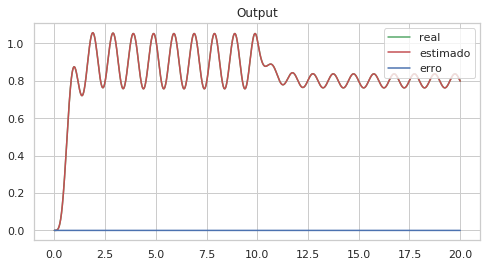

In [19]:
# plot output: real vs estimated and residual
fig,axes = plt.subplots(figsize=(8,4))

axes.set_title("Output")
axes.plot(t,yr,color='g',label="real")
axes.plot(t,yh,color='r',label="estimado")
axes.plot(t,e,color='b',label="erro")
#axes.set_ylim([0,1])
axes.legend(loc=1)

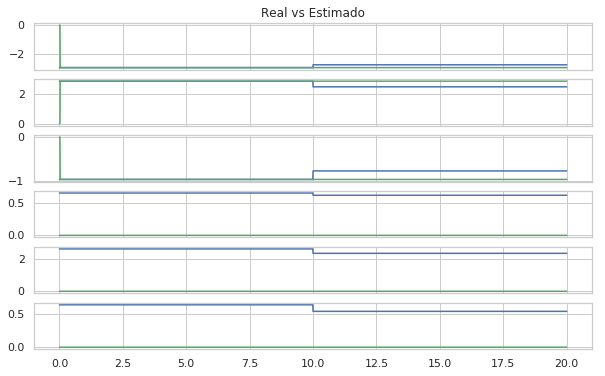

In [20]:
# plot output: real vs estimated
fig,axes = plt.subplots(nrows=6, ncols=1, figsize=(10,6))

axes[0].set_title("Real vs Estimado")
axes[0].plot(t,a1,color='b',label="real")
axes[0].plot(t,a1h,color='g',label="estimado")

axes[1].plot(t,a2,color='b',label="real")
axes[1].plot(t,a2h,color='g',label="estimado")

axes[2].plot(t,a3,color='b',label="real")
axes[2].plot(t,a3h,color='g',label="estimado")

axes[3].plot(t,b1,color='b',label="real")
axes[3].plot(t,b1h,color='g',label="estimado")

axes[4].plot(t,b2,color='b',label="real")
axes[4].plot(t,b2h,color='g',label="estimado")

axes[5].plot(t,b3,color='b',label="real")
axes[5].plot(t,b3h,color='g',label="estimado")